In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import math
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import SilhouetteVisualizer
from tqdm.notebook import tqdm, tnrange
import timeit
from time import sleep

from sklearn import manifold
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

In [2]:
flierprop = {"marker": "o", "markersize": "5"}

meanprop = {
    "marker": "o",
    "markerfacecolor": "white",
    "markeredgecolor": "black",
    "markersize": "7"
}

boxprop = dict(boxstyle='round', facecolor='w',
               alpha=0.8)  # Param. pour annotations

timelapse = []

if not os.path.exists('P5_clustering'):
    os.makedirs('P5_clustering')

## ARI - Déterminer la période d'update du modèle

In [3]:
if not os.path.exists('P5_clustering/kmeans_ARI'):
    os.makedirs('P5_clustering/kmeans_ARI')

In [4]:
timestamps = pd.read_csv("timestamps.csv", sep=",")
print("Commande la plus récente: " +
      str(timestamps.order_purchase_timestamp.max()))
print("Commande la plus ancienne: " +
      str(timestamps.order_purchase_timestamp.min()))
tmax = pd.to_datetime(timestamps.order_purchase_timestamp.max())
tmin = pd.to_datetime(timestamps.order_purchase_timestamp.min())

timestamps['order_purchase_timestamp'] = pd.to_datetime(
    timestamps.order_purchase_timestamp).dt.to_period('M')

Commande la plus récente: 2018-09-03
Commande la plus ancienne: 2016-09-04


In [5]:
print(tmin)
print(tmax)

delta = int((tmax - tmin) / np.timedelta64(1, 'M'))

print(delta)

2016-09-04 00:00:00
2018-09-03 00:00:00
23


In [6]:
ref = 12  # période de ref (1 an)
interval = 4  # intervale entre périodes = 4 mois

start_ref = tmin.to_period('M')
end_ref = tmin.to_period('M') + ref

clients_ref = timestamps[(timestamps.order_purchase_timestamp >= start_ref)
                         & (timestamps.order_purchase_timestamp <= end_ref
                            )].customer_unique_id.unique()

print(str(len(clients_ref)) + " clients sur la période de référence")

# recalcul des features
# total_pay et review_score
df_ref = timestamps[timestamps.customer_unique_id.isin(clients_ref)].groupby(
    'customer_unique_id').sum()['total_pay'].to_frame().join(
        timestamps[timestamps.customer_unique_id.isin(clients_ref)].groupby(
            'customer_unique_id').mean()['review_score'])

# récence et fréquence (step 1)
df_ref["N"] = 0
clients_n = timestamps[timestamps.order_purchase_timestamp <= start_ref +
                       interval].customer_unique_id.unique()
df_ref.loc[df_ref.index.isin(clients_n), "N"] = 1

df_ref["N1"] = 0
clients_n1 = timestamps[
    (timestamps.order_purchase_timestamp >= start_ref + interval)
    & (timestamps.order_purchase_timestamp <= start_ref +
       2 * interval)].customer_unique_id.unique()
df_ref.loc[df_ref.index.isin(clients_n1), "N1"] = 1

df_ref["N2"] = 0
clients_n2 = timestamps[
    (timestamps.order_purchase_timestamp >= start_ref + 2 * interval)
    & (timestamps.order_purchase_timestamp <= end_ref
       )].customer_unique_id.unique()
df_ref.loc[df_ref.index.isin(clients_n2), "N2"] = 1

26453 clients sur la période de référence


In [7]:
# Frequence : savoir si le client a commandé au moins une fois dans les périodes concernées
intervales = ['N', 'N1', 'N2']
df_ref['Frequence'] = 0

for cust in tqdm(df_ref.index, desc="Calcul de fréquences"):
    df_ref.loc[cust, 'Frequence'] = np.count_nonzero(df_ref.loc[cust,
                                                                intervales],
                                                     axis=0)

df_ref.sort_values(by='Frequence')

Calcul de fréquences:   0%|          | 0/26453 [00:00<?, ?it/s]

,total_pay,review_score,N,N1,N2,Frequence
customer_unique_id,,,,,,
0000f46a3911fa3c0805444483337064,86.22,3.000000,0,1,0,1
914109f0341b3d9ef93293a76c1fb5c2,31.75,5.000000,0,0,1,1
9136946b6b16453f79f2dfcef449486e,53.33,1.000000,0,0,1,1
9130059f7c7d7f3c6f270e9141a90ece,41.75,4.000000,0,0,1,1
912c80f32c41b9e56400ef8e073a866b,42.00,5.000000,0,0,1,1
...,...,...,...,...,...,...
d2f38262a9f66d15aa9fc2b60ea873d9,170.47,5.000000,1,1,1,3
9d31457a03125fc870787a251760315a,320.17,5.000000,1,1,1,3
523730e4b2ef7654c243699b81763112,229.83,5.000000,1,1,1,3


In [8]:
# récence
intervales = {'N2': 3, 'N1': 2, 'N': 1}

df_ref['Recence'] = 0

for cust in tqdm(df_ref.index):
    for intv in intervales:
        if df_ref[intv][cust] == 0:
            continue

        else:
            df_ref.loc[cust, 'Recence'] = intervales[intv]
            break
df_freq = df_ref[['N', 'N1', 'N2']]
df_ref.drop(columns=['N', 'N1', 'N2'], inplace=True)

  0%|          | 0/26453 [00:00<?, ?it/s]

In [9]:
df_ref.review_score.fillna(df_ref.review_score.mean(), inplace=True)
df_ref['total_pay'] = np.log2(df_ref['total_pay'])
df_ref

,total_pay,review_score,Frequence,Recence
customer_unique_id,,,,
0000f46a3911fa3c0805444483337064,6.429951,3.0,1,2
0005e1862207bf6ccc02e4228effd9a0,7.229972,4.0,1,2
0006fdc98a402fceb4eb0ee528f6a8d4,4.857981,3.0,1,3
000a5ad9c4601d2bbdd9ed765d5213b3,6.512227,4.0,1,3
000bfa1d2f1a41876493be685390d6d3,6.549977,4.5,1,3
...,...,...,...,...
fff3a9369e4b7102fab406a334a678c3,6.682854,5.0,1,3
fff699c184bcc967d62fa2c6171765f7,5.781360,4.0,1,3
fffcf5a5ff07b0908bd4e2dbc735a684,11.013616,5.0,1,3


In [10]:
colsRef = df_ref.columns

# scaling
Xref = MinMaxScaler().fit_transform(df_ref)
Xref = pd.DataFrame(Xref, columns=colsRef)

# Init k_means
kmean_model = KMeans(n_clusters=4)
kmean_y = kmean_model.fit(Xref)

labels_ref = kmean_model.labels_
df_ref['labels'] = labels_ref

df_ref.groupby('labels').mean()

,total_pay,review_score,Frequence,Recence
labels,,,,
0,6.801613,4.740227,1.000000,3.000000
1,6.892504,1.736878,1.121567,2.736830
2,6.855925,4.553813,2.002070,2.835188
3,6.799371,4.542047,1.000000,1.960293


/home/camille/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


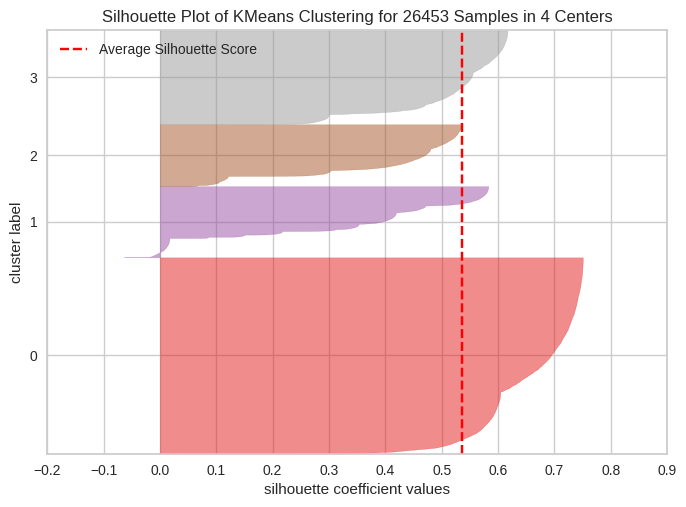

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 26453 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [11]:
# K-means silhouette score
visualizer = SilhouetteVisualizer(kmean_model)
visualizer.fit(Xref) 
visualizer.show()

In [12]:
df_ref

,total_pay,review_score,Frequence,Recence,labels
customer_unique_id,,,,,
0000f46a3911fa3c0805444483337064,6.429951,3.0,1,2,3
0005e1862207bf6ccc02e4228effd9a0,7.229972,4.0,1,2,3
0006fdc98a402fceb4eb0ee528f6a8d4,4.857981,3.0,1,3,1
000a5ad9c4601d2bbdd9ed765d5213b3,6.512227,4.0,1,3,0
000bfa1d2f1a41876493be685390d6d3,6.549977,4.5,1,3,0
...,...,...,...,...,...
fff3a9369e4b7102fab406a334a678c3,6.682854,5.0,1,3,0
fff699c184bcc967d62fa2c6171765f7,5.781360,4.0,1,3,0
fffcf5a5ff07b0908bd4e2dbc735a684,11.013616,5.0,1,3,0


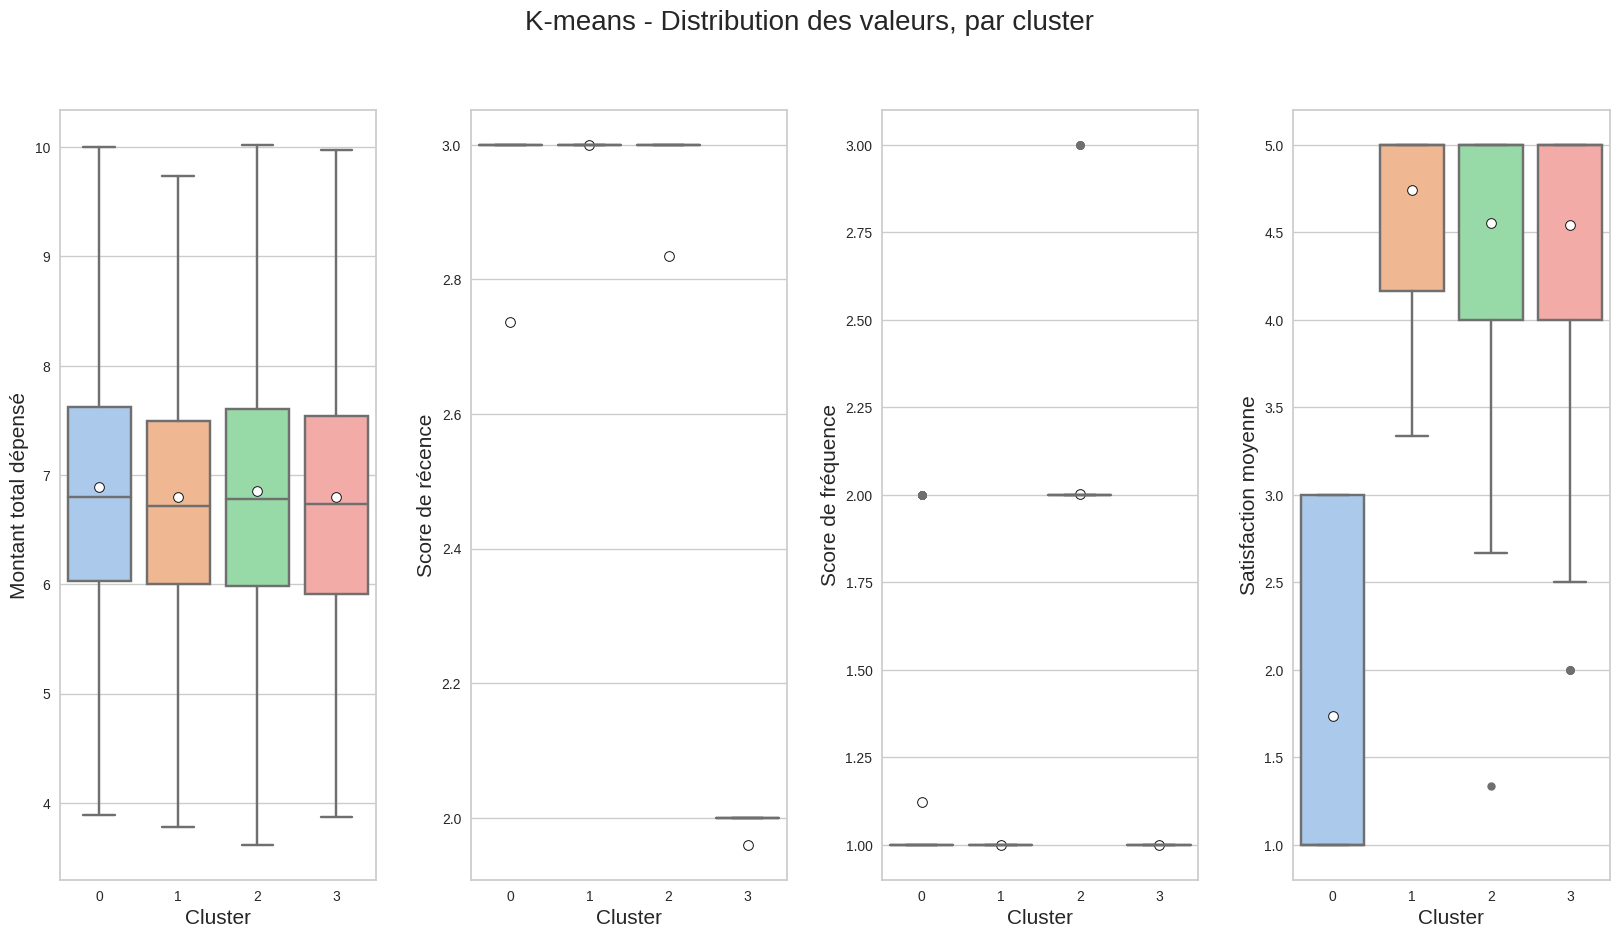

In [27]:
kmean_model = KMeans(n_clusters=4)
kmean_y = kmean_model.fit(Xref)

df_ref['labels'] = kmean_model.labels_

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))

sns.boxplot(y="total_pay",
            x='labels',
            data=df_ref,
            showfliers=False,
            ax=ax1,
            palette='pastel')
myn = df_ref.groupby('labels').mean()['total_pay']
ax1.scatter(myn.index,
            myn,
            marker='o',
            facecolor='w',
            edgecolor='k',
            linewidths=0.7)
ax1.set_ylabel('Montant total dépensé', fontsize=15)
ax1.set_xlabel('Cluster', fontsize=15)

sns.boxplot(y="Recence",
            x='labels',
            data=df_ref,
            showfliers=False,
            ax=ax2,
            palette='pastel')
myn = df_ref.groupby('labels').mean()['Recence']
ax2.scatter(myn.index,
            myn,
            marker='o',
            facecolor='w',
            edgecolor='k',
            linewidths=0.7)

ax2.set_ylabel('Score de récence', fontsize=15)
ax2.set_xlabel('Cluster', fontsize=15)

sns.boxplot(y="Frequence",
            x='labels',
            data=df_ref,
            showfliers=True,
            ax=ax3,
            palette='pastel',
            flierprops=flierprop)
myn = df_ref.groupby('labels').mean()['Frequence']
ax3.scatter(myn.index,
            myn,
            marker='o',
            facecolor='w',
            edgecolor='k',
            linewidths=0.7)

ax3.set_ylabel('Score de fréquence', fontsize=15)
ax3.set_xlabel('Cluster', fontsize=15)

sns.boxplot(y="review_score",
            x='labels',
            data=df_ref,
            showfliers=True,
            ax=ax4,
            palette='pastel',
            flierprops=flierprop)
myn = df_ref.groupby('labels').mean()["review_score"]
ax4.scatter(myn.index,
            myn,
            marker='o',
            facecolor='w',
            edgecolor='k',
            linewidths=0.7)

ax4.set_ylabel('Satisfaction moyenne', fontsize=15)
ax4.set_xlabel('Cluster', fontsize=15)

plt.subplots_adjust(wspace=0.3)
fig.suptitle("K-means - Distribution des valeurs, par cluster", fontsize=20)
plt.savefig("P5_clustering/kmeans_ARI/boxplot_clusters.png",
            bbox_inches='tight')

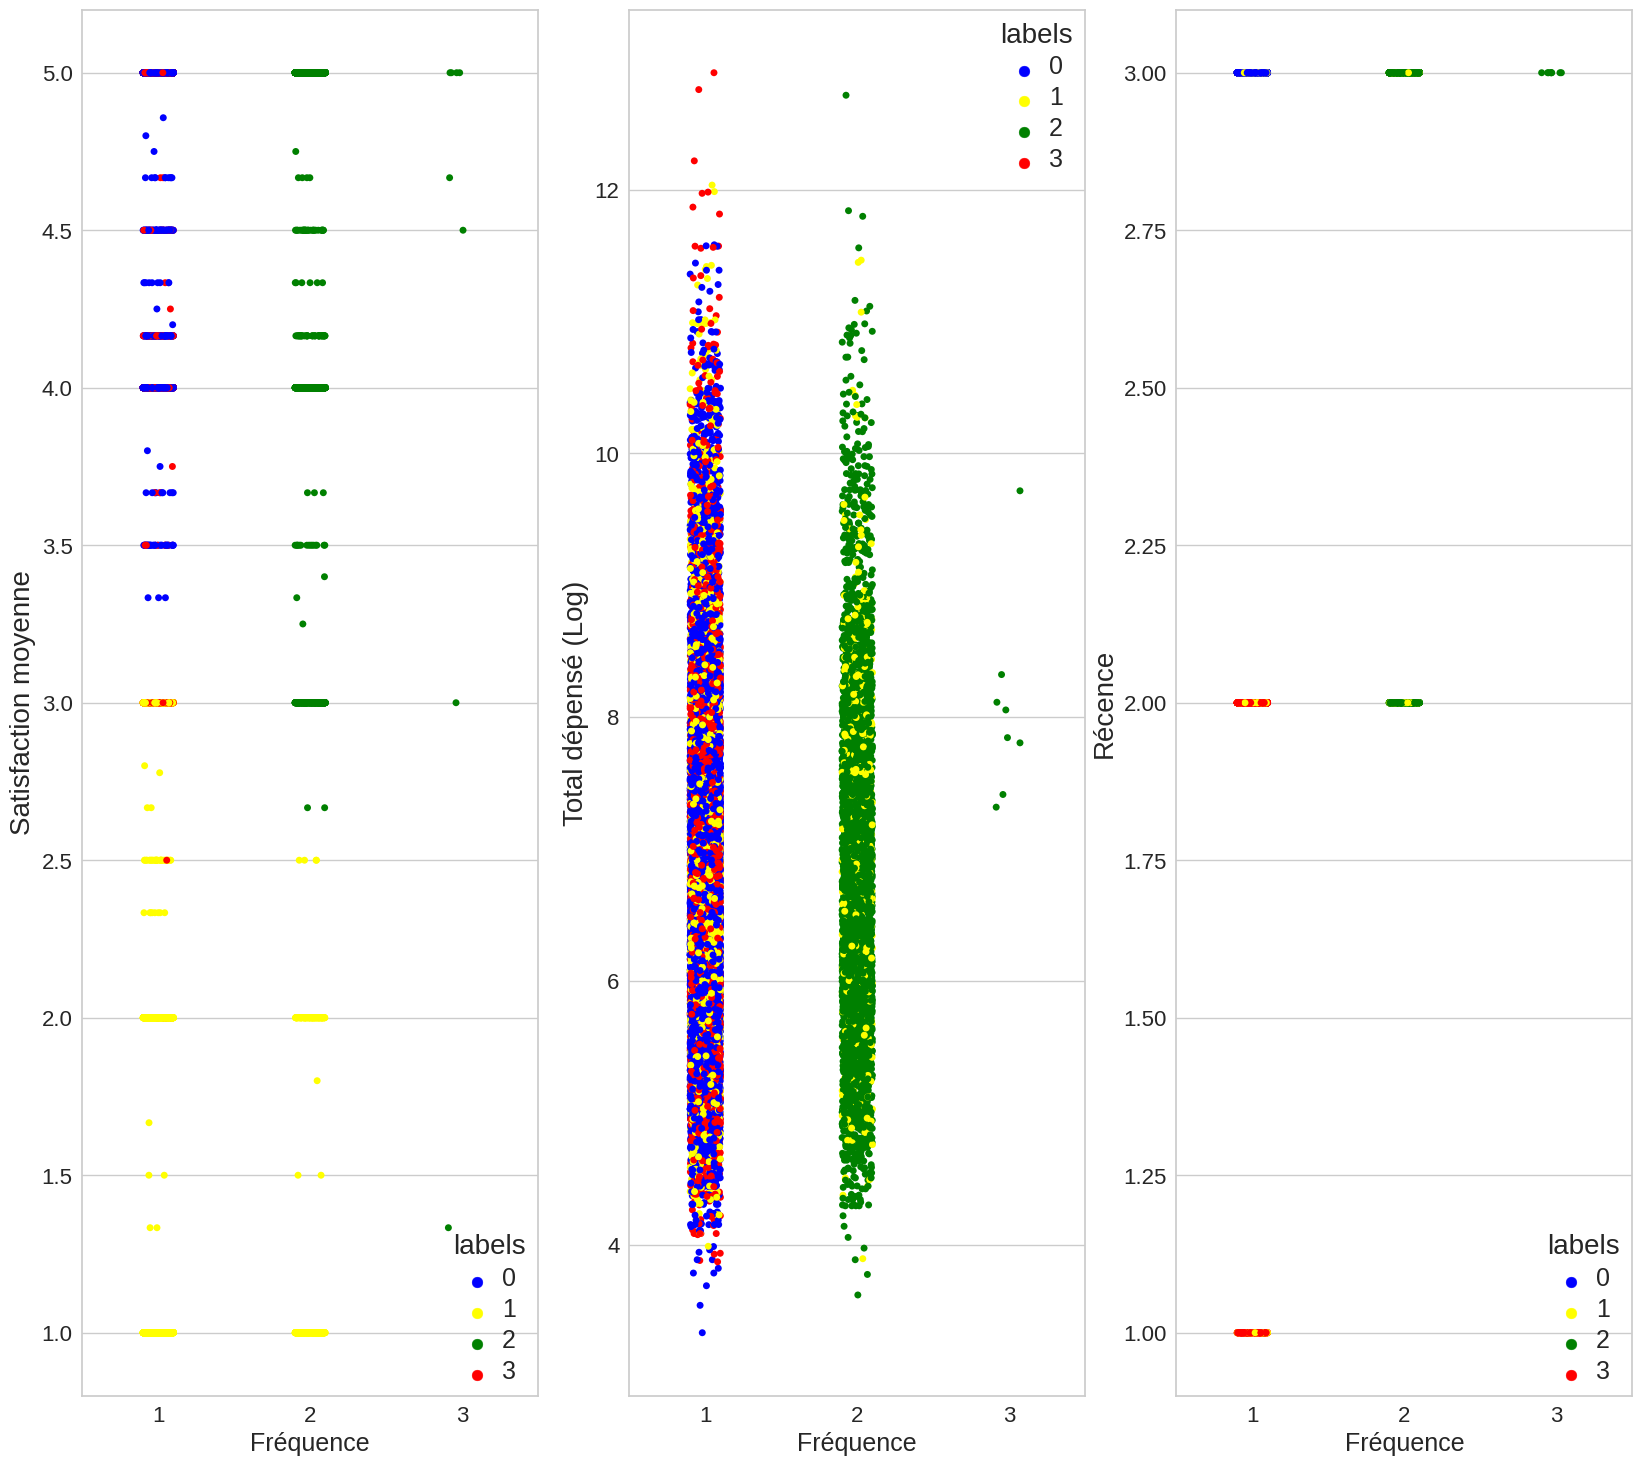

In [13]:
colonnes = {
    'review_score': 'Satisfaction moyenne',
    'total_pay': 'Total dépensé (Log)',
    'Recence': 'Récence'
}
colors = ['blue', 'yellow', 'green', 'red']

fig, axes = plt.subplots(1, 3, figsize=(20, 18), sharex=False)

for i in range(0, len(colonnes)):
    col = list(colonnes)[i]

    ax = sns.stripplot(x=df_ref['Frequence'],
                       y=df_ref[col].values,
                       hue=df_ref['labels'],
                       jitter=True,
                       ax=axes[(i)],
                       palette=colors)

    ax.set_ylabel(list(colonnes.values())[i], fontsize=20)
    ax.set_xlabel('Fréquence', fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=16)
    plt.setp(ax.get_legend().get_texts(), fontsize='18')
    plt.setp(ax.get_legend().get_title(), fontsize='20')

plt.savefig("P5_clustering/kmeans_alldata/stripplot_clusters_ref.png",
            bbox_inches='tight')

In [14]:
tsne = manifold.TSNE(n_components=2,
                     init="pca",
                     learning_rate="auto",
                     perplexity=50,
                     n_iter=1000)
trans_data = tsne.fit_transform(df_ref)

/home/camille/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


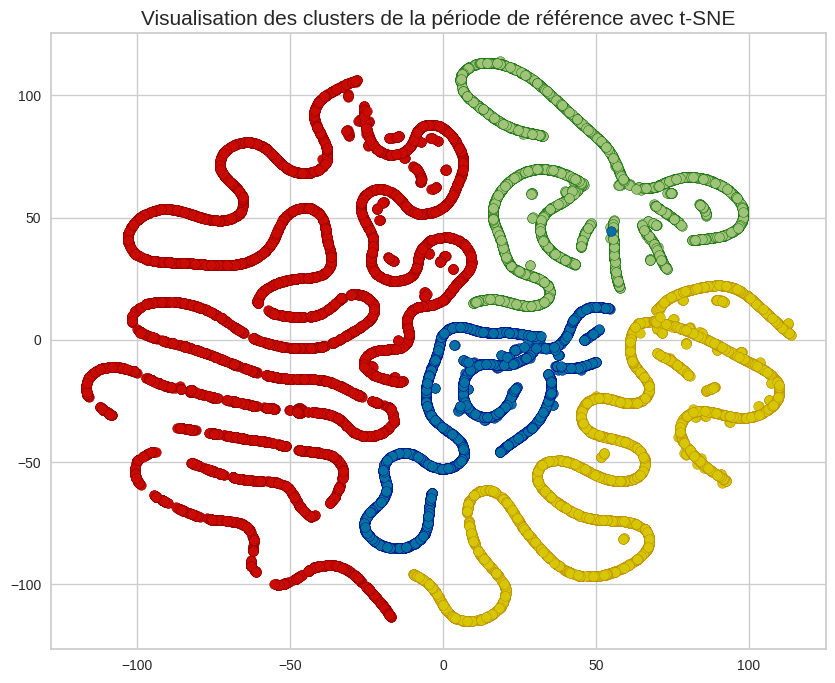

In [15]:
dfref_transdata = pd.DataFrame(trans_data, index=df_ref.index)
dfref_transdata = dfref_transdata.merge(df_ref['labels'],
                                        left_index=True,
                                        right_index=True)

colors = ['r', 'g', 'b', 'y']
edge = ['darkred', 'darkgreen', 'darkblue', 'darkgoldenrod']

fig, ax = plt.subplots(figsize=(10, 8))

for label in dfref_transdata.labels.unique():
    tmp = dfref_transdata[dfref_transdata.labels == label]
    plt.scatter(tmp[0], tmp[1], color=colors[label],edgecolor=edge[label])
plt.title("Visualisation des clusters de la période de référence avec t-SNE", fontsize=15)
plt.savefig("P5_clustering/kmeans_ARI/TSNE_Ref_clusters.png",
            bbox_inches='tight')

plt.show()

In [16]:
 df_ref.groupby('labels').mean()

,total_pay,review_score,Frequence,Recence
labels,,,,
0,6.801613,4.740227,1.000000,3.000000
1,6.892504,1.736878,1.121567,2.736830
2,6.855925,4.553813,2.002070,2.835188
3,6.799371,4.542047,1.000000,1.960293


In [17]:
ref = 12  # période de ref (1 an)
interval = 4  # intervale entre périodes = 4 mois

intervales = {'N2': 3, 'N1': 2, 'N': 1}
scoreM = []

scaler = MinMaxScaler()

# ici là quoi oker je vois ça stente (redefinir le scaler ici des fois que ????)

RangeM = range(0, 6, 1)

for i in tqdm(RangeM):

    # sélection des commandes dans la période voulue
    df_tmp = timestamps[timestamps.order_purchase_timestamp <= end_ref + i]

    # sélection des clients en commun avec la période de ref et calcul du total de commande + review score moyen
    df_tmp = df_tmp[df_tmp.customer_unique_id.isin(clients_ref)].groupby(
        'customer_unique_id').sum()['total_pay'].to_frame().join(
            df_tmp[df_tmp.customer_unique_id.isin(clients_ref)].groupby(
                'customer_unique_id').mean()['review_score'])

    df_tmp.review_score.fillna(df_tmp.review_score.mean(), inplace=True)
    df_tmp['total_pay'] = np.log2(df_tmp['total_pay'])

    if i > 0:
        # sélection des clients qui ont commandé sur la nouvelle période
        clients_nx = timestamps[
            (timestamps.order_purchase_timestamp >= end_ref)
            & (timestamps.order_purchase_timestamp <= end_ref +
               i)].customer_unique_id.unique()

        df_tmp["N3"] = 0
        df_tmp.loc[df_tmp.index.isin(clients_nx), "N3"] = 1
        intervales = {'N3': 4, 'N2': 3, 'N1': 2, 'N': 1}

    df_tmp = df_tmp.join(df_freq)

    df_tmp['Frequence'] = 0
    for cust in df_tmp.index:
        df_tmp.loc[cust, 'Frequence'] = np.count_nonzero(
            df_tmp.loc[cust, list(intervales.keys())], axis=0)

    df_tmp['Recence'] = 0
    for cust in df_tmp.index:
        for intv in intervales:
            if df_tmp[intv][cust] == 0:
                continue

            else:
                df_tmp.loc[cust, 'Recence'] = intervales[intv]
                break

    #df_tmp['Recence']=np.power(df_tmp['Recence'],20)

    df_tmp.drop(columns=list(intervales.keys()), inplace=True)

    ### Clustering
    colsTmp = df_tmp.columns

    # scaling
    Xtmp = scaler.fit_transform(df_tmp)
    Xtmp = pd.DataFrame(Xtmp, columns=colsTmp, index=df_tmp.index)

    # Init k_means
    kmeans_model = KMeans(n_clusters=4)

    kmeans_model.fit(df_ref.drop(columns='labels'))
    y_before = kmeans_model.predict(Xtmp)

    #df_tmp['ctrl_labels'] = y_before

    kmeans_model_refit = kmeans_model.fit(Xtmp)
    y_after = kmeans_model_refit.predict(Xtmp)

    df_tmp['test'] = y_after

    scoreM_df = df_ref.labels.rename('ctrl').to_frame().merge(df_tmp.test,
                                                              left_index=True,
                                                              right_index=True)

    scoreM.append(
        round(metrics.adjusted_rand_score(scoreM_df.ctrl, scoreM_df.test), 2))

  0%|          | 0/6 [00:00<?, ?it/s]

In [18]:
# les valeurs sont entre 0 et 1 (normalisées)
df_centroids=pd.DataFrame(np.round(kmeans_model.cluster_centers_,4),columns=kmeans_model.feature_names_in_)
df_centroids

,total_pay,review_score,Frequence,Recence
0,0.3615,0.9314,0.0327,0.3204
1,0.3688,0.2225,0.0928,0.5791
2,0.3726,0.9109,0.3376,0.8607
3,0.3568,0.9357,-0.0000,0.6667


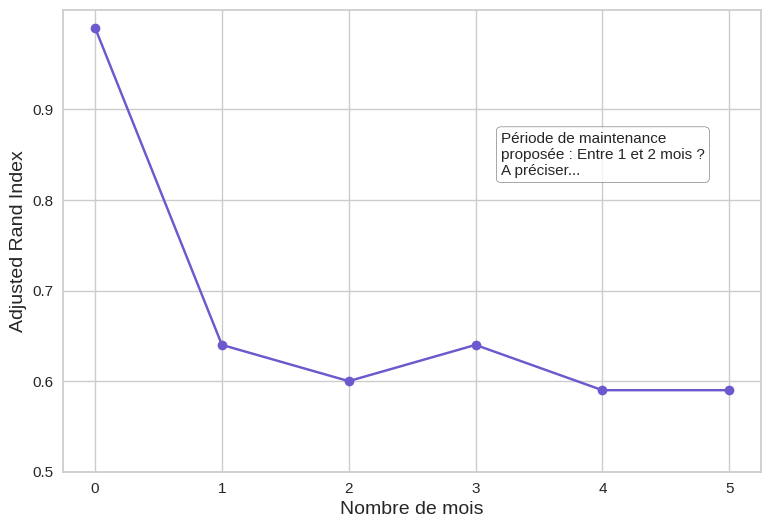

In [19]:
textstr = "Période de maintenance \nproposée : Entre 1 et 2 mois ?\nA préciser..."

scoreS = pd.Series(scoreM, index=RangeM)

fig, ax = plt.subplots(figsize=(9, 6))

ax.text(3.2,
        0.85,
        textstr,
        fontsize=11,
        verticalalignment='center',
        bbox=boxprop)

plt.plot(scoreS.index.tolist(), scoreS, 'o-', color='slateblue')
plt.xticks(ticks=RangeM, size=11)
plt.yticks(ticks=np.arange(0.5, 1, 0.1), size=11)
plt.xlabel(xlabel='Nombre de mois', size=14)
plt.ylabel(ylabel='Adjusted Rand Index', size=14)


plt.savefig("P5_clustering/kmeans_ARI/adjRandSc_1M.png", bbox_inches='tight')

# Jours

In [20]:
ref = 365  # période de ref (1 an)
interval = 120  # intervale entre périodes = 4 mois
timestamps = pd.read_csv("timestamps.csv", sep=",")
timestamps['order_purchase_timestamp'] = pd.to_datetime(
    timestamps.order_purchase_timestamp).dt.to_period('D')

start_ref = tmin.to_period('D')
end_ref = tmin.to_period('D') + ref
Range = np.arange(0, 180, 15)

########### TESTS EN JOURS ###########

scaler = MinMaxScaler()

intervales = {'N2': 3, 'N1': 2, 'N': 1}
score = []

for i in tqdm(Range):

    # sélection des commandes dans la période voulue
    df_tmp = timestamps[timestamps.order_purchase_timestamp <= end_ref + i]
    #   df_tmp=timestamps[(timestamps.order_purchase_timestamp<=end_ref+i) & (timestamps.order_purchase_timestamp>=start_ref+i)]

    # sélection des clients en commun avec la période de ref et calcul du total de commande + review score moyen
    df_tmp = df_tmp[df_tmp.customer_unique_id.isin(clients_ref)].groupby(
        'customer_unique_id').sum()['total_pay'].to_frame().join(
            df_tmp[df_tmp.customer_unique_id.isin(clients_ref)].groupby(
                'customer_unique_id').mean()['review_score'])

    df_tmp.review_score.fillna(df_tmp.review_score.mean(), inplace=True)
    df_tmp['total_pay'] = np.log2(df_tmp['total_pay'])

    if i > 0:
        # sélection des clients qui ont commandé sur la nouvelle période
        clients_nx = timestamps[
            (timestamps.order_purchase_timestamp >= end_ref)
            & (timestamps.order_purchase_timestamp <= end_ref +
               i)].customer_unique_id.unique()

        df_tmp["N3"] = 0
        df_tmp.loc[df_tmp.index.isin(clients_nx), "N3"] = 1
        intervales = {'N3': 4, 'N2': 3, 'N1': 2, 'N': 1}

    df_tmp = df_tmp.join(df_freq)

    df_tmp['Frequence'] = 0
    for cust in df_tmp.index:
        df_tmp.loc[cust, 'Frequence'] = np.count_nonzero(
            df_tmp.loc[cust, list(intervales.keys())], axis=0)

    df_tmp['Recence'] = 0
    for cust in df_tmp.index:
        for intv in intervales:
            if df_tmp[intv][cust] == 0:
                continue

            else:
                df_tmp.loc[cust, 'Recence'] = intervales[intv]
                break

    #df_tmp['Recence']=np.power(df_tmp['Recence'],20)

    df_tmp.drop(columns=list(intervales.keys()), inplace=True)

    ### Clustering
    colsTmp = df_tmp.columns

    # scaling
    Xtmp = MinMaxScaler().fit_transform(df_tmp)
    Xtmp = pd.DataFrame(Xtmp, columns=colsTmp, index=df_tmp.index)

    # Init k_means
    kmeans_model = KMeans(n_clusters=4)

    kmeans_model.fit(df_ref.drop(columns='labels'))
    y_before = kmeans_model.predict(Xtmp)

    #df_tmp['ctrl_labels'] = y_before

    kmeans_model_refit = kmeans_model.fit(Xtmp)
    y_after = kmeans_model_refit.predict(Xtmp)

    df_tmp['test'] = y_after

    #    score_df=df_ref.labels.rename('ctrl').to_frame().join(df_tmp.test)

    score_df = df_ref.labels.rename('ctrl').to_frame().merge(df_tmp.test,
                                                             left_index=True,
                                                             right_index=True)

    print('df_score size : ' + str(score_df.shape))
    score.append(
        round(metrics.adjusted_rand_score(score_df.ctrl, score_df.test), 2))

  0%|          | 0/12 [00:00<?, ?it/s]

df_score size : (22880, 2)
df_score size : (25040, 2)
df_score size : (26453, 2)
df_score size : (26453, 2)
df_score size : (26453, 2)
df_score size : (26453, 2)
df_score size : (26453, 2)
df_score size : (26453, 2)
df_score size : (26453, 2)
df_score size : (26453, 2)
df_score size : (26453, 2)
df_score size : (26453, 2)


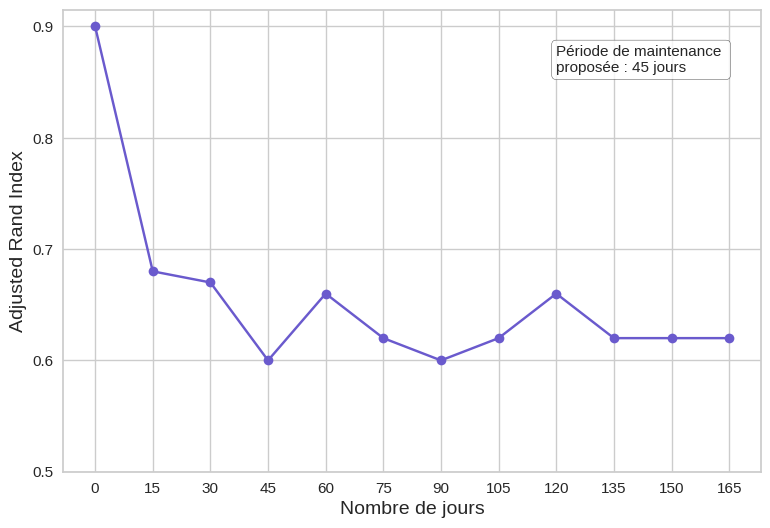

In [21]:
textstr = "Période de maintenance \nproposée : 45 jours"

scoreS = pd.Series(score, index=Range)

fig, ax = plt.subplots(figsize=(9, 6))

ax.text(120,
        0.87,
        textstr,
        fontsize=11,
        verticalalignment='center',
        bbox=boxprop)

plt.plot(scoreS.index.tolist(), scoreS, 'o-', color='slateblue')
plt.xticks(ticks=Range, size=11)
plt.yticks(ticks=np.arange(0.5, 1, 0.1), size=11)
plt.xlabel(xlabel='Nombre de jours', size=14)
plt.ylabel(ylabel='Adjusted Rand Index', size=14)

plt.savefig("P5_clustering/kmeans_ARI/adjRandSc_15J.png", bbox_inches='tight')

- méthode de proximité des produits / méthode de proximité des acteurs 
- AB testing
- algo principaux : kmeans, regression logistiques et linéaires. faciles et ça donne déjà plein de bonnes solutions
- "word to vec" bcp mieux que "n word", qui marche mieux que les chaînes de markov
- marketingcopy.ai



- k-medoid -> K-means c la moyenne, ben là c'est la médiane dans un hyperplan. L'intérêt c'est que du coup les centres de cluster c'est des médianes donc des individus représentatifs des clusters qui existent (et pas un individu théorique)